# TUTORIAL FOR TRAVELING SALESMAN PROBLEM

__Introduction__: The famous travelling salesman problem (also called the travelling salesperson problem or in short TSP) is a well-known NP-hard problem in combinatorial optimization, asking for the shortest possible route that visits each city exactly once, given a list of cities and the distances between each pair of cities [1]. 
Applications of the TSP can be found in planning, logistics, and the manufacture of microchips. 
In these applications, the general concept of a city represents, for example, customers, or points on a chip. 

__Methods__: Using brute-force search one could try all permutations (ordered combinations) and see which one is cheapest. 
The running time for this approach, however, lies within a polynomial factor of $O(n!)$, the factorial of the number of cities $n$. 
Thus, this solution becomes impractical already for only $\sim 20$ cities. 
Still, many heuristics are known, and some instances with tens of thousands of cities can be solved completely [1]. 
In this hello-world tutorial we will solve small instances of the TSP with one particular approach, that is simulated annealing and quantum annealing, as made available with D-Wave on Amazon Braket. 
Specifically, we will leverage two different quantum devices made available through Amazon Braket, namely D-Wave's 2000Q QPU (with 2000 qubits and 6000 couplers) and D-Wave's Advantage QPU (with more than 5000 qubits and more than 35,000 couplers). 

__TSP as graph problem__: 
The solution to the TSP can be viewed as a specific ordering of the vertices in a weighted graph.
Taking an undirected weighted graph, cities correspond to the graph's nodes, with paths corresponding to the graph's edges, and a path's distance is the edge's weight. 
Typically, the graph is complete where each pair of nodes is connected by an edge. 
If no connection exists between two cities, one can add an arbitrarily long edge to complete the graph without affecting the optimal tour [1].
The goal is then to find a Hamiltonian cycle with the least weight. 
We will provide figures for visualization below. 

__Binary encoding__: To solve the TSP with (quantum) annealing we need to formulate the TSP as a QUBO problem of the general form 

$$
\mathrm{min} \hspace{0.1cm} y=x^{\intercal}Qx + x^{\intercal}B + c,
$$ 

where $x=(x_{1}, x_{2}, \dots)$ is a vector of binary decision variables $x_{i}=0,1$. 
To this end, here we introduce double-indexed binary variables $x_{i,j}$ with $x_{i,j}=1$ if city $i$is located at position $j$ in the cycle and $x_{i,j}=0$ otherwise. 
Consider for example three cities: New York indexed with $i=0$, Los Angeles ($i=1$), and Chicago ($i=2$). 
Then, $x_{0,0}=x_{1,2}=x_{2,1}=1$ means that we visit these cities in the order New York - Chicago - Los Angeles. 
With this encoding $x_{i,j}$ with $i=0,\dots, N-1$ and $j=0,\dots, N-1$ in total we deal with $N^2$ binary variables for a problem with $N$ cities (nodes in the graph), causing a quadratic overhead.  

Our goal is then to find the Hamiltonian cycle with the shortest length, as described by the following objective function

$$
H_{\mathrm{dist}} = \sum_{i,j} D_{i,j} \sum_{k} x_{i,k}x_{j,k+1},
$$

with $D_{i,j}$ being the distance between city $i$ and city $j$. Note that the product $x_{i,k}x_{j,k+1}=1$, only if city $i$ is at position $k$ in the cycle and city $j$ is visited right after city $i$; in that case we add the distance $D_{i,j}$ to our objective function which we would like to minimize. 
Overall, we sum all costs of the distances between successive cities. 

Finally, we need to account for the following constraints: 
(i) First, each city should occur exactly once in the cycle. This can be written as: 
$$
\sum_{j=0}^{N-1} x_{i,j}=1 \hspace{0.5cm} \forall i=0,...,N-1.
$$
(ii) Second, each position in the cycle should be assigned to exactly one city. Mathematically this means:
$$
\sum_{i=0}^{N-1} x_{i,j}=1 \hspace{0.5cm} \forall j=0,...,N-1.
$$

For illustration a valid solution for $N=4$ for the route $[1,3,2,4]$ could look as follows (note that every row and column sums up to one, as desired):

<div>
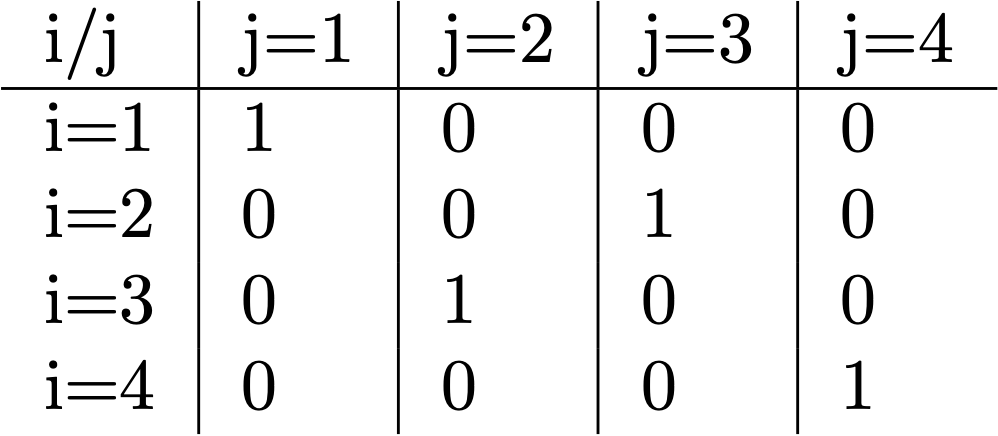
</div>

To enforce solutions that satisfy these constraints we add the following penalty terms to our Hamiltonian

$$
H_{\mathrm{constraint}} = P \sum_{i=0}^{N-1} \left(1-\sum_{j=0}^{N-1} x_{i,j}\right)^{2} + P \sum_{j=0}^{N-1} \left(1-\sum_{i=0}^{N-1} x_{i,j}\right)^{2}
$$

With these terms we enforce solutions where every city is visited exactly once as part of the tour. 
Otherwise, a high penalty value $P$ would be added to the solution, making it unfavorable. 
For simplicity we use the same penalty parameter $P$ for the two types of constraints covered in $H_{\mathrm{constraint}}$. 

The total Hamiltonian for the TSP problem then reads

$$
H = H_{\mathrm{dist}} + H_{\mathrm{constraint}}.
$$

We will perform hyperparameter optimization on the penalty parameter $P$ in order to find a good solution that complies with the constraints outlined above. 
If $P$ is not chosen properly it is possible that the algorithm provides solutions that are not acceptable, for example routes that do not cover all cities or routes that visit some cities multiple times. 
In our code below we apply simple heuristic postprocessing steps to account for these issues. 

## IMPORTS AND SETUP

In [1]:
!pip install pandas -q

In [7]:
import boto3
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [8]:
import numpy as np
import networkx as nx
import dimod
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
from collections import defaultdict
import itertools
import pandas as pd

In [9]:
# local imports
from utils_tsp import get_distance, traveling_salesperson

%load_ext autoreload
%autoreload 2

In [10]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-1a222675c751" # the name of the bucket
my_prefix = "annealer-experiment" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [11]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

## IMPORT DATASET

Sample datasets for TSP are available [here](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html).
Here, we start with a very small dataset comprising five cities only. 
The minimal tour is known to have length 19.

In [12]:
# load dataset
data = pd.read_csv('tsp_data/five_d.txt', sep='\s+', header=None)

In [13]:
# show data set for inter-city distances
data

,0,1,2,3,4
0,0.0,3.0,4.0,2.0,7.0
1,3.0,0.0,4.0,6.0,3.0
2,4.0,4.0,0.0,5.0,8.0
3,2.0,6.0,5.0,0.0,6.0
4,7.0,3.0,8.0,6.0,0.0


In [14]:
# distance between two example cities
idx_city1 = 0
idx_city2 = 1
distance = data[idx_city1][idx_city2]
print('Distance between city {} and city {} is {}.'.format(idx_city1, idx_city2, distance))

Distance between city 0 and city 1 is 3.0.


In [15]:
# get number of cities
number_cities = data.shape[0]
print('Total number of cities:', number_cities)

Total number of cities: 5


## SET UP GRAPH

We can generate ```networkx``` graphs from ```pandas``` data frames, as explained [here](https://networkx.github.io/documentation/stable/reference/convert.html#pandas) and in particular [here](https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_adjacency.html?highlight=from%20pandas#networkx.convert_matrix.from_pandas_adjacency).

In [16]:
# G = nx.from_pandas_dataframe(data) 
G = nx.from_pandas_adjacency(data)
# pos = nx.random_layout(G) 
pos = nx.spring_layout(G, seed=seed)

# get characteristics of graph
nodes = G.nodes()
edges = G.edges()
weights = nx.get_edge_attributes(G,'weight');

In [17]:
# print weights of graph
print('Weights of graph:', weights)

Weights of graph: {(0, 1): 3.0, (0, 2): 4.0, (0, 3): 2.0, (0, 4): 7.0, (1, 2): 4.0, (1, 3): 6.0, (1, 4): 3.0, (2, 3): 5.0, (2, 4): 8.0, (3, 4): 6.0}


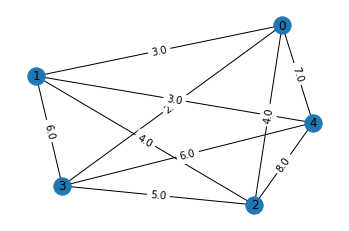

In [18]:
# show graph with weigths
plt.axis('off'); 
nx.draw_networkx(G, pos, with_labels=True);
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights);

The weights of this fully-connected graph correspond to the distances between the cities. 

## QUBO FOR TSP

We can get the QUBO matrix using the ```traveling_salesperson_qubo``` method as described [here](https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/latest/reference/algorithms/generated/dwave_networkx.algorithms.tsp.traveling_salesperson_qubo.html#dwave_networkx.algorithms.tsp.traveling_salesperson_qubo).
This method will return the QUBO with ground states corresponding to a minimum TSP route.
Here, if $|G|$ is the number of nodes (cities) in the original graph, the resulting QUBO will have $|G|^2$ variables/nodes
and $|G|^2(|G|^2-1)/2$ edges. 
There is a quadratic overhead because of the binary encoding $x_{i,j}=1$ if city $i$ is at position $j$ on the route and zero otherwise. 
The Lagrange penalty parameter enforces the constraints that every city should be visited exactly once in our route (i.e., we do not leave out any city and we do not visit cities multiple times). 
As this parameter can be tuned we will run hyperparameter optimization (HPO) to find a good value for this hyperparameter. 

In [19]:
# get QUBO for TSP
tsp_qubo = dnx.algorithms.tsp.traveling_salesperson_qubo(G)

In [20]:
# find default Langrange parameter for enforcing constraints

# set parameters
lagrange = None
weight='weight'

# get corresponding QUBO step by step
N = G.number_of_nodes()

if lagrange is None:
    # If no lagrange parameter provided, set to 'average' tour length.
    # Usually a good estimate for a lagrange parameter is between 75-150%
    # of the objective function value, so we come up with an estimate for 
    # tour length and use that.
    if G.number_of_edges()>0:
        lagrange = G.size(weight=weight)*G.number_of_nodes()/G.number_of_edges()
    else:
        lagrange = 2

print('Default Lagrange parameter:', lagrange)   

Default Lagrange parameter: 24.0


In [21]:
# create list around default value for HPO 
lagrange_list= list(np.arange(int(0.8*lagrange), int(1.1*lagrange)))
print('Lagrange parameter for HPO:', lagrange_list)

Lagrange parameter for HPO: [19, 20, 21, 22, 23, 24, 25]


## SOLUTION WITH SIMULATED ANNEALING

First let us solve the TSP problem with classical simulated annealing.
To this end we can simply call the built-in ```traveling_salesperson(...)``` routine from the ```dwave_networkx``` package using the ```SimulatedAnnealingSampler``` sampler as provided in the standard Ocean tool suite. 

In [22]:
# use (classical) simulated annealing
sampler = dimod.SimulatedAnnealingSampler()
# route = dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0)
route = dnx.traveling_salesperson(G, sampler, start=0)
print('Route found with simulated annealing:', route)

Route found with simulated annealing: [0, 3, 4, 1, 2]


In [23]:
# get the total distance
total_dist = 0
for idx, node in enumerate(route[:-1]):
    dist = data[route[idx+1]][route[idx]]
    total_dist += dist

print('Total distance (without return):', total_dist)

Total distance (without return): 15.0


In [24]:
# add distance between start and end point to complete cycle
return_distance = data[route[0]][route[-1]]
print('Distance between start and end:', return_distance)

Distance between start and end: 4.0


In [25]:
# get distance for full cyle 
distance = total_dist + return_distance
print('Total distance (including return):', distance)

Total distance (including return): 19.0


## SOLUTION WITH QUANTUM ANNEALING ON D-WAVE WITH HPO FOR LAGRANGE PARAMETER

Now let us run the TSP problem on D-Wave's 2000Q QPU, together with hyperparameter optimization for the Langrange parameter.
To this end, we augment the ```traveling_salesperson(...)``` routine with post-processing heuristics that correct for invalid solutions if some cities are not present in the sample produced by D-Wave or if some cities are duplicates in the route. 
The original source code for ```traveling_salesperson(...)``` can be found in the Appendix. 

In [26]:
# run TSP with imported TSP routine
sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)

# set parameters
num_shots = 1000
start_city = 0
best_distance = sum(weights.values())
best_route = [None]*len(G)

# run HPO to find route
for lagrange in lagrange_list:
    print('Running quantum annealing for TSP with Lagrange parameter=', lagrange)
    route = traveling_salesperson(G, sampler, lagrange=lagrange, 
                                  start=start_city, num_reads=num_shots, answer_mode="histogram")
    # print route 
    print('Route found with D-Wave:', route)
    
    # print distance
    total_dist, distance_with_return = get_distance(route, data)
    
    # update best values
    if distance_with_return < best_distance:
        best_distance = distance_with_return
        best_route = route

print('---FINAL SOLUTION---')
print('Best solution found with D-Wave:', best_route)
print('Total distance (including return):', best_distance)

Running quantum annealing for TSP with Lagrange parameter= 19


Now let us visualize the solution found by the D-Wave QPU. 
First we plot again the original graph with nodes representing cities and weighted edges representing distances between the cities. 
It is a complete graph showing the distance for every pair of cities. 
Then, we plot below the graph showing the proposed route, with steps labelling the specific sequence connecting the individual stops on the route. 

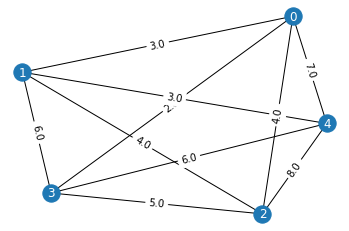

In [ ]:
# show original graph with weigths
plt.axis('off'); 
nx.draw_networkx(G, pos, with_labels=True, font_color='w');
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights);

In [ ]:
# get mapping from original nodes to position in cycle
node_labels = {list(nodes)[ii]: best_route[ii] for ii in range(number_cities)}

In [ ]:
# Construct route as list of (node_i, node_i+1)
sol_graph_base = [(best_route[idx], best_route[idx+1]) for idx in range(len(best_route)-1)]
# Establish weights between nodes along route, allowing for mirrored keys (i.e. weights[(0, 1)] = weights[(1, 0)])
best_weights = {k: weights[k] if k in weights.keys() else weights[(k[1],k[0])] for k in sol_graph_base}
# Rebuild graph containing only route connections
G_best = nx.Graph(sol_graph_base)

route_labels = {x: f'step_{i}={best_weights[x]}' for i, x in enumerate(sol_graph_base)}

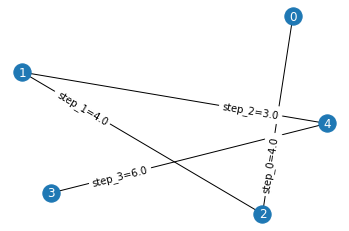

In [ ]:
# show solution
plt.axis('off'); 
nx.draw_networkx(G_best, pos, font_color='w');
nx.draw_networkx_edge_labels(G_best, pos, edge_labels=route_labels, label_pos=0.25);

In conclusion, in this part of our tutorial we have solved a very small instance of the famous NP-hard TSP problem using both (classical) simulated annealing and quantum annealing using D-Wave's Ocean tool suite that is natively supported on Amazon Braket. 
While there are classical methods that can solve this problem very efficiently, at least to a very good approximation, this is an educational tutorial focused on the formulation of a specific QUBO problem and the approximate solution thereof using (quantum) annealing methods. 
Below we extend our analysis to larger problem sizes that cannot be embedded on the 2000Q D-Wave chip with Chimera connectivity, but can be run on the larger Advantage chip with $\sim 5000$ physical variables and Pegasus connectivity. 

## LARGER TSP PROBLEM ON D-WAVE ADVANTAGE CHIP

Next we run a larger problem instance of TSP on D-Wave's Advantage chip with over 5000 physical qubits and Pegasus connectivity graph. 
We take a dataset comprising ten cities; we have taken the original data set with 15 cities from [here](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html) and cut it down to a smaller dataset containing only the first ten cities. 
First let us load and inspect the data set for the inter-city distances. 

In [ ]:
# load dataset
data10 = pd.read_csv('tsp_data/data10cities.csv')
# rename columns from object to int 
dic_map = {}
for key in data10.columns:
    d = {key: int(key)}
    dic_map.update(d)
data10 = data10.rename(columns=dic_map)
# show data set for inter-city distances
data10

,0,1,2,3,4,5,6,7,8,9
0,0,29,82,46,68,52,72,42,51,55
1,29,0,55,46,42,43,43,23,23,31
2,82,55,0,68,46,55,23,43,41,29
3,46,46,68,0,82,15,72,31,62,42
4,68,42,46,82,0,74,23,52,21,46
5,52,43,55,15,74,0,61,23,55,31
6,72,43,23,72,23,61,0,42,23,31
7,42,23,43,31,52,23,42,0,33,15
8,51,23,41,62,21,55,23,33,0,29
9,55,31,29,42,46,31,31,15,29,0


Next, using the ```networkx``` library again we display this problem as a complete graph with a single node per city and weighted edges specifying the intercity distances. 

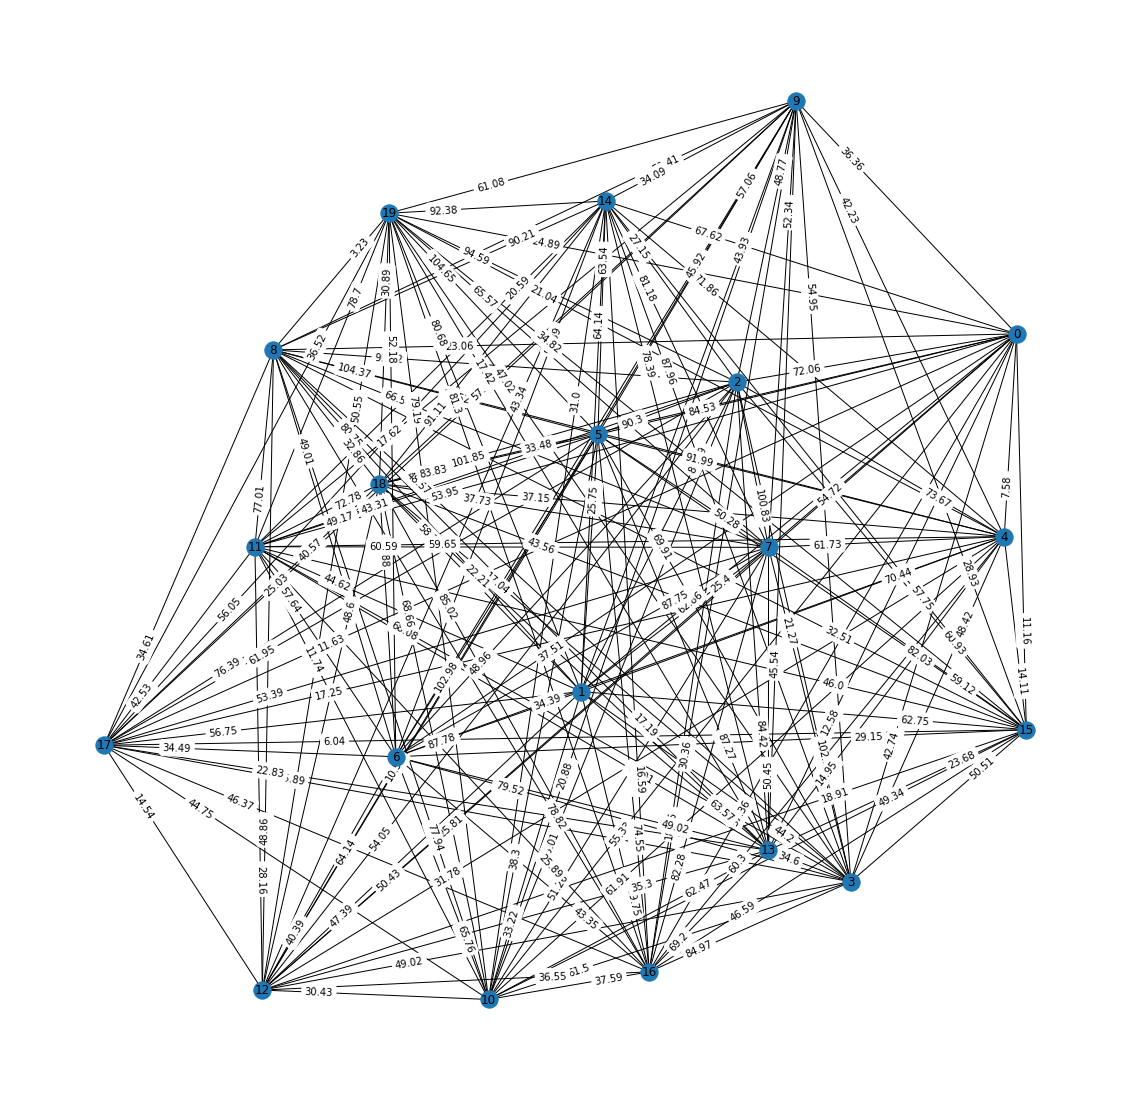

In [ ]:
# G = nx.from_pandas_dataframe(data) 
G = nx.from_pandas_adjacency(data10)
# pos = nx.random_layout(G) 
pos = nx.spring_layout(G, seed=seed)

# get characteristics of graph
nodes = G.nodes()
edges = G.edges()
weights = nx.get_edge_attributes(G,'weight');

# show graph with weigths
plt.figure(figsize=(num_city,num_city))
plt.axis('off'); 
nx.draw_networkx(G, pos, with_labels=True);
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, label_pos=0.25);

Now that the problem is set up as a graph problem, we first use classical simulated annealing to easily build a classical benchmark, using the ```SimulatedAnnealingSampler``` that comes out of the box with the ```dimod``` library. 

In [ ]:
# use (classical) simulated annealing
sampler = dimod.SimulatedAnnealingSampler()
# route = dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0)
route = dnx.traveling_salesperson(G, sampler, start=0)
print('Route found with simulated annealing:', route)

Route found with simulated annealing: [0, 3, 1, 2, 4]


In [ ]:
# print distance
total_dist, distance_with_return = get_distance(route, data)

Total distance (without return): 24.841638934716098
Total distance (including return): 25.600019164597857


Below again we will run HPO to try several numerical values for the hyperparameter $P$ enforcing the constraints within the cost function.
To this end we first set up a list of parameters to loop over later in our simulation routine. 

In [ ]:
# find default Langrange parameter for enforcing constraints

# set parameters
lagrange = None
weight='weight'

# get corresponding QUBO step by step
N = G.number_of_nodes()

if lagrange is None:
    # If no lagrange parameter provided, set to 'average' tour length.
    # Usually a good estimate for a lagrange parameter is between 75-150%
    # of the objective function value, so we come up with an estimate for 
    # tour length and use that.
    if G.number_of_edges()>0:
        lagrange = G.size(weight=weight)*G.number_of_nodes()/G.number_of_edges()
    else:
        lagrange = 2

print('Default Lagrange parameter:', lagrange)   

Default Lagrange parameter: 1036.5873684210528


In [ ]:
# create list around default value for HPO 
# lagrange_list= list(np.arange(int(0.99*lagrange), int(1.01*lagrange)))
lagrange_list= [int(lagrange)-10, int(lagrange), int(lagrange)+10]
print('Lagrange parameter for HPO:', lagrange_list)

Lagrange parameter for HPO: [1026, 1036, 1046]


Next, we try to run this problem on D-Wave's 2000Q backend with Chimera connectivity. 
Here, we will run into an ```ValueError: no embedding found```, because a problem with 10 cities results in a fully-connected problem with 100 logical variables. 
This problem size cannot be embedded onto the sparse Chimera graph with $\sim 2000$ physical qubits. 
Therefore we will try to run the same problem on the larger Advantage chip below. 

In [ ]:
# run TSP on 2000Q chip
sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)

# set parameters
num_shots = 1000
start_city = 0

try: 
    print('Running quantum annealing for TSP with Lagrange parameter=', lagrange)
    route = traveling_salesperson(G, sampler, lagrange=lagrange_list[0], 
                                  start=start_city, num_reads=num_shots, answer_mode="histogram")
    # print route 
    print('Route found with D-Wave:', route)
except ValueError:
    print("ValueError: no embedding found. This problem is too large to be embedded on the 2000Q chip.")

Running quantum annealing for TSP with Langrgange parameter= 438.0
ValueError: no embedding found. This problem is too large to be embedded on the 2000Q chip.


Next we simply switch to the D-Wave's Advantage chip with over 5000 physical qubits and Pegasus connectivity graph. 
This switch amounts to changing one line of code. 

In [ ]:
# run TSP on Advantage chip
sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/Advantage_system4')
sampler = EmbeddingComposite(sampler)

# set parameters
num_shots = 1000
start_city = 0
best_distance = sum(weights.values())
best_route = [None]*len(G)

# run HPO to find route
for lagrange in lagrange_list:
    print('Running quantum annealing for TSP with Lagrange parameter=', lagrange)
    route = traveling_salesperson(G, sampler, lagrange=lagrange, 
                                  start=start_city, num_reads=num_shots, answer_mode="histogram")
    # print route 
    print('Route found with D-Wave:', route)
    
    # print distance
    total_dist, distance_with_return = get_distance(route, data)
    
    # update best values
    if distance_with_return < best_distance:
        best_distance = distance_with_return
        best_route = route

print('---FINAL SOLUTION---')
print('Best solution found with D-Wave:', best_route)
print('Total distance (including return):', best_distance)

1
2


In conclusion in this tutorial we have mapped the canonical TSP to a QUBO problem using the Ocean tool suite that is natively supported on Amazon Braket. 
We have used classical simulated annealing and quantum annealing to find solutions to this problem. 
Specifically, we have seen that we can solve larger problem instances with the Advantage chip (that has more than 5000 qubits and more than 35,000 couplers) than what we could solve for using the previous-generation 2000Q QPU with roughly 2000 qubits and 6000 couplers. 

### Below is the method to generate random data for TSP problem, please use this tool to test the limitation of current quantum device for TSP problem

In [5]:
import numpy as np
from scripts.plots import plot_cities

num_city = 12
seed = 2021

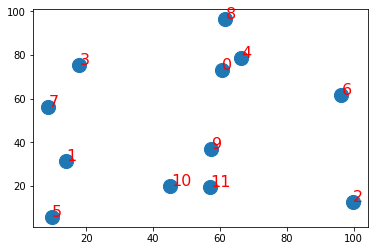

In [6]:
def create_cities(N):
    """
    Creates an array of random points of size N.
    """
    cities = []
    np.random.seed(seed)
    for i in range(N):
        cities.append(np.round((np.random.rand(2) * 100),2))
    return np.array(cities)

cities = create_cities(num_city)
plot_cities(cities)

In [ ]:
import itertools

def distance_between_points(point_A, point_B):
    return np.round(np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2),2)

def get_distance_matrix(cities):
    number_of_cities = len(cities)
    matrix = np.zeros((number_of_cities, number_of_cities))
    for i in range(number_of_cities):
        for j in range(i, number_of_cities):
            matrix[i][j] = distance_between_points(cities[i], cities[j])
            matrix[j][i] = matrix[i][j]
    return matrix

distance_matrix = get_distance_matrix(cities)

In [ ]:
import pandas as pd

data = pd.DataFrame(distance_matrix)

---
## APPENDIX

### APPENDIX FOR HEURISTIC POSTPROCESSING

If there are cities unassigned to route, we just fill the route with these without optimization. 
First, we can take care of filling ```None``` values. 

In [31]:
# set example route
route = [None, 4, 0, 3, 1]
print('Original route:', route)
# get lists with all cities
list_cities = list(nodes)
# get not assigned cities
cities_unassigned = [city for city in list_cities if city not in route] 
# fill None values
for idx, city in enumerate(route):
    if city == None:
        route[idx] = cities_unassigned[0]
        cities_unassigned.remove(route[idx])
print('Route after filling heuristic:', route)

Original route: [None, 4, 0, 3, 1]
Route after filling heuristic: [2, 4, 0, 3, 1]


In [32]:
# randomly permute
cities_unassigned = [0, 4, 7]
np.random.permutation(cities_unassigned)

array([0, 7, 4])

Second, we can still have proposed routes with cities appearing multiple times in exchange for some cities not visited at all. 

In [33]:
# set example route
route = [0, 2, 3, 4, 4]
print('Original route:', route)
unique_entries = set(route)
number_unique_entries = len(unique_entries)
if number_unique_entries != len(route):
    print('Solution not valid.')
# get unassigned cities
cities_unassigned = [city for city in list_cities if city not in route]
print('Unassigned cities:', cities_unassigned)

# replace duplicates
route_new = []
for city in route:
    if city not in route_new:
        route_new.append(city)
    else:
        route_new.append(cities_unassigned[0])
        cities_unassigned.remove(route_new[-1])
print('Route after heuristics:', route_new)

Original route: [0, 2, 3, 4, 4]
Solution not valid.
Unassigned cities: [1, 5, 6, 7, 8, 9]
Route after heuristics: [0, 2, 3, 4, 1]


In [34]:
# set example route
route = [0, 0, 1, 1, 1]
print('Original route:', route)
unique_entries = set(route)
number_unique_entries = len(unique_entries)
if number_unique_entries != len(route):
    print('Solution not valid.')
# get unassigned cities
cities_unassigned = [city for city in list_cities if city not in route]
print('Unassigned cities:', cities_unassigned)

# replace duplicates
route_new = []
for city in route:
    if city not in route_new:
        route_new.append(city)
    else:
        route_new.append(cities_unassigned[0])
        cities_unassigned.remove(route_new[-1])
print('Route after heuristics:', route_new)

Original route: [0, 0, 1, 1, 1]
Solution not valid.
Unassigned cities: [2, 3, 4, 5, 6, 7, 8, 9]
Route after heuristics: [0, 2, 1, 3, 4]


###  APPENDIX: ORIGINAL SOURCE CODE WITH LINKS

Here we display the ocean source code used above for solving the TSP problem. 
We show the code for both ```traveling_salesperson(...)``` taken from [here](https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/latest/_modules/dwave_networkx/algorithms/tsp.html#traveling_salesperson) and ```traveling_salesperson_qubo(...)``` taken from [here](https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/latest/_modules/dwave_networkx/algorithms/tsp.html#traveling_salesperson_qubo).

```python
@binary_quadratic_model_sampler(1)
def traveling_salesperson(G, sampler=None, lagrange=None, weight='weight',
                          start=None, **sampler_args):
    """Returns an approximate minimum traveling salesperson route.

    Defines a QUBO with ground states corresponding to the
    minimum routes and uses the sampler to sample
    from it.

    A route is a cycle in the graph that reaches each node exactly once.
    A minimum route is a route with the smallest total edge weight.

    Parameters
    ----------
    G : NetworkX graph
        The graph on which to find a minimum traveling salesperson route.
        This should be a complete graph with non-zero weights on every edge.

    sampler :
        A binary quadratic model sampler. A sampler is a process that
        samples from low energy states in models defined by an Ising
        equation or a Quadratic Unconstrained Binary Optimization
        Problem (QUBO). A sampler is expected to have a 'sample_qubo'
        and 'sample_ising' method. A sampler is expected to return an
        iterable of samples, in order of increasing energy. If no
        sampler is provided, one must be provided using the
        `set_default_sampler` function.

    lagrange : number, optional (default None)
        Lagrange parameter to weight constraints (visit every city once)
        versus objective (shortest distance route).

    weight : optional (default 'weight')
        The name of the edge attribute containing the weight.

    start : node, optional
        If provided, the route will begin at `start`.

    sampler_args :
        Additional keyword parameters are passed to the sampler.

    Returns
    -------
    route : list
       List of nodes in order to be visited on a route

    Examples
    --------

    >>> import dimod
    ...
    >>> G = nx.Graph()
    >>> G.add_weighted_edges_from({(0, 1, .1), (0, 2, .5), (0, 3, .1), (1, 2, .1),
    ...                            (1, 3, .5), (2, 3, .1)})
    >>> dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0) # doctest: +SKIP
    [0, 1, 2, 3]

    Notes
    -----
    Samplers by their nature may not return the optimal solution. This
    function does not attempt to confirm the quality of the returned
    sample.

    """
    # Get a QUBO representation of the problem
    Q = traveling_salesperson_qubo(G, lagrange, weight)

    # use the sampler to find low energy states
    response = sampler.sample_qubo(Q, **sampler_args)

    sample = response.first.sample

    route = [None]*len(G)
    for (city, time), val in sample.items():
        if val:
            route[time] = city

    if start is not None and route[0] != start:
        # rotate to put the start in front
        idx = route.index(start)
        route = route[idx:] + route[:idx]

    return route
```

```python
def traveling_salesperson_qubo(G, lagrange=None, weight='weight'):
    """Return the QUBO with ground states corresponding to a minimum TSP route.

    If :math:`|G|` is the number of nodes in the graph, the resulting qubo will have:

    * :math:`|G|^2` variables/nodes
    * :math:`2 |G|^2 (|G| - 1)` interactions/edges

    Parameters
    ----------
    G : NetworkX graph
        A complete graph in which each edge has a attribute giving its weight.

    lagrange : number, optional (default None)
        Lagrange parameter to weight constraints (no edges within set)
        versus objective (largest set possible).

    weight : optional (default 'weight')
        The name of the edge attribute containing the weight.

    Returns
    -------
    QUBO : dict
       The QUBO with ground states corresponding to a minimum travelling
       salesperson route. The QUBO variables are labelled `(c, t)` where `c`
       is a node in `G` and `t` is the time index. For instance, if `('a', 0)`
       is 1 in the ground state, that means the node 'a' is visted first.

    """
    N = G.number_of_nodes()

    if lagrange is None:
        # If no lagrange parameter provided, set to 'average' tour length.
        # Usually a good estimate for a lagrange parameter is between 75-150%
        # of the objective function value, so we come up with an estimate for 
        # tour length and use that.
        if G.number_of_edges()>0:
            lagrange = G.size(weight=weight)*G.number_of_nodes()/G.number_of_edges()
        else:
            lagrange = 2

    # some input checking
    if N in (1, 2) or len(G.edges) != N*(N-1)//2:
        msg = "graph must be a complete graph with at least 3 nodes or empty"
        raise ValueError(msg)

    # Creating the QUBO
    Q = defaultdict(float)

    # Constraint that each row has exactly one 1
    for node in G:
        for pos_1 in range(N):
            Q[((node, pos_1), (node, pos_1))] -= lagrange
            for pos_2 in range(pos_1+1, N):
                Q[((node, pos_1), (node, pos_2))] += 2.0*lagrange

    # Constraint that each col has exactly one 1
    for pos in range(N):
        for node_1 in G:
            Q[((node_1, pos), (node_1, pos))] -= lagrange
            for node_2 in set(G)-{node_1}:
                # QUBO coefficient is 2*lagrange, but we are placing this value 
                # above *and* below the diagonal, so we put half in each position.
                Q[((node_1, pos), (node_2, pos))] += lagrange

    # Objective that minimizes distance
    for u, v in itertools.combinations(G.nodes, 2):
        for pos in range(N):
            nextpos = (pos + 1) % N

            # going from u -> v
            Q[((u, pos), (v, nextpos))] += G[u][v][weight]

            # going from v -> u
            Q[((v, pos), (u, nextpos))] += G[u][v][weight]

    return Q

```

---
## REFERENCES

[1] Wikipedia: [Travelling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem).